In [1]:
import math
import time
import xarray as xr

In [2]:
ds = xr.open_dataset('data/spatial_storm_data_part1.nc')
print(ds.values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (patch: 90000, y: 32, x: 32)
Dimensions without coordinates: patch, y, x
Data variables: (12/24)
    tk_1km   (patch, y, x) float32 ...
    tk_3km   (patch, y, x) float32 ...
    tk_5km   (patch, y, x) float32 ...
    tk_7km   (patch, y, x) float32 ...
    ev_1km   (patch, y, x) float32 ...
    ev_3km   (patch, y, x) float32 ...
    ...       ...
    pr_5km   (patch, y, x) float32 ...
    pr_7km   (patch, y, x) float32 ...
    wmax     (patch, y, x) float32 ...
    dbz      (patch, y, x) float32 ...
    ctt      (patch, y, x) float32 ...
    uh25     (patch, y, x) float32 ...>


In [21]:
# Calculate uh25max
uh25mx = ds['uh25'].max(['y','x'],skipna=True).values

# Bin uh25max into classes
n_class = 20
class_sep = 0.2

# This allows easy use of an arbitrary number of classes
# Can replace max(uh25mx) with another value for more consistent results
class_size = max(uh25mx) / n_class
print(class_size)
print(max(uh25mx))

uh_class = []
for val in uh25mx:
    # Actual class size = class_size * (1 - separation)
    val_class = math.floor(val / class_size)
    
    # Remove the bottom (separation*100)% of data within this class
    if val - (class_size * val_class) < class_size * class_sep:
        uh_class.append(-1)
    else:
        uh_class.append(val_class)

3.745030975341797
74.90062


In [114]:
# Create new Dataset with coordinates and an uh_cls column
dff = xr.Dataset(data_vars={
    
    'tk_1km': (['patch','y','x'], ds['tk_1km'].data),
    'tk_3km': (['patch','y','x'], ds['tk_3km'].data),
    'tk_5km': (['patch','y','x'], ds['tk_5km'].data),
    'tk_7km': (['patch','y','x'], ds['tk_7km'].data),
    
    'ev_1km': (['patch','y','x'], ds['ev_1km'].data),
    'ev_3km': (['patch','y','x'], ds['ev_3km'].data),
    'ev_5km': (['patch','y','x'], ds['ev_5km'].data),
    'ev_7km': (['patch','y','x'], ds['ev_7km'].data),
    
    'eu_1km': (['patch','y','x'], ds['eu_1km'].data),
    'eu_3km': (['patch','y','x'], ds['eu_3km'].data),
    'eu_5km': (['patch','y','x'], ds['eu_5km'].data),
    'eu_7km': (['patch','y','x'], ds['eu_7km'].data),
    
    'qv_1km': (['patch','y','x'], ds['qv_1km'].data),
    'qv_3km': (['patch','y','x'], ds['qv_3km'].data),
    'qv_5km': (['patch','y','x'], ds['qv_5km'].data),
    'qv_7km': (['patch','y','x'], ds['qv_7km'].data),
    
    'pr_1km': (['patch','y','x'], ds['pr_1km'].data),
    'pr_3km': (['patch','y','x'], ds['pr_3km'].data),
    'pr_5km': (['patch','y','x'], ds['pr_5km'].data),
    'pr_7km': (['patch','y','x'], ds['pr_7km'].data),
    
    'wmax'  : (['patch','y','x'], ds['wmax'].data),
    'dbz'   : (['patch','y','x'], ds['dbz'].data),
    'ctt'   : (['patch','y','x'], ds['ctt'].data),
    'uh_cls': (['patch'], uh_class),
}, coords = dict(patch=ds['patch'], x=ds['x'], y=ds['y']))

dff

<xarray.Dataset>
Dimensions:  (patch: 90000, y: 32, x: 32)
Coordinates:
  * patch    (patch) int64 0 1 2 3 4 5 6 ... 89994 89995 89996 89997 89998 89999
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Data variables: (12/24)
    tk_1km   (patch, y, x) float32 282.8 282.9 283.0 283.0 ... 271.5 271.9 272.5
    tk_3km   (patch, y, x) float32 271.5 271.8 271.9 271.7 ... 263.2 263.3 263.4
    tk_5km   (patch, y, x) float32 261.2 261.0 260.8 260.6 ... 248.8 248.9 249.1
    tk_7km   (patch, y, x) float32 249.0 249.0 248.8 248.7 ... 232.5 232.8 233.3
    ev_1km   (patch, y, x) float32 7.451 7.606 7.312 ... -10.38 -9.96 -9.21
    ev_3km   (patch, y, x) float32 -4.403 -4.094 -3.466 ... 0.6359 0.4319 0.2873
    ...       ...
    pr_5km   (patch, y, x) float32 544.3 545.4 546.1 546.6 ... 491.4 493.2 496.9
    pr_7km   (patch, y, x) float32 416.5 417.2 417.8 418.1 ... 370.2 371.6 374.6
    wmax     (patch, y, x) float32 0.4052 0.4673 0.5187 ... 0.303 0.1509 0.1795
    dbz      (patch, y, x) float32 1.175 -6.168 -3.375 ... 24.36 22.78 30.94
    ctt      (patch, y, x) float32 7.94 8.177 8.35 ... -0.4655 -0.2271 0.2532
    uh_cls   (patch) int32 0 0 0 -1 0 0 0 0 0 0 0 0 ... 4 0 -1 4 1 0 0 -1 4 4 -1

In [135]:
# Separate dataset into source and target task
# split: 0-1, train/test split --> split*100% train, (1-split)*100% test
# domain_gap: 0.0 = smallest gap, 1.0 = largest gap
split = 0.8
domain_gap = 0.0

n_class = 20

# Calculate number of (source) classes to populate w/ high domain gap and low domain gap
# For now, we leave these as floats
high_cls = n_class * domain_gap * split
low_cls = n_class * (1-domain_gap) * split

# Populate high gap classes
# If domain_gap == 1.0, source_cls = [x <= n_class * split], target_cls = [x > n_class * split]
source_cls = [x for x in range(math.floor(high_cls))]

# Populate low gap classes
# These will be evenly distributed across the rest of the classes
for i in range(math.ceil(low_cls)):
    source_cls.append(math.floor((i * (n_class - high_cls) / low_cls) + high_cls))

# Populate target classes w/ all classes not in source task
# Note: this is necessary to eliminate patches that aren't in any class
target_cls = [x for x in range(n_class) if x not in source_cls]

# Generate list of patch indices to drop for source and target task
# There might be a better way to do this but this results in more uniform execution time
source_drop_idx = []
target_drop_idx = []
for i in range(len(uh_class)):
    if uh_class[i] not in source_cls:
        source_drop_idx.append(i)
    if uh_class[i] not in target_cls:
        target_drop_idx.append(i)
        
start = time.time()

# For some reason, this converts the uh_cls column from int32 to float64
source_task = dff.drop_isel(patch=source_drop_idx)
target_task = dff.drop_isel(patch=target_drop_idx)

print("Execution time:", time.time() - start, "s")

Execution time: 24.705899477005005 s


In [19]:
# FULL FUNCTION IMPLEMENTATION
import math
import time
import pickle
import numpy as np
import xarray as xr
import seaborn as sns

# This is a non-validation version
def split_data(datasrc='../deep-conus-master/data/spatial_storm_data_part1.nc',
               n_class=20, class_sep=0.2, split=0.4, domain_gap=1.0):
    # Parameters:
    # datasrc = filename, default ../deep-conus-master/data/spatial_storm_data_part1.nc
    # n_class = number of classes to generate when binning
    # class_sep = separation between classes, i.e. fraction that gets dropped of each class
    # split = train/test split
    # domain_gap = decides how train/test classes are selected; 1.0 = max domain gap, 0.0 = min domain gap

    # Open Dataset
    ds = xr.open_dataset(datasrc)
    
    print("Dataset open. Binning classes and adding coordinates.")

    # Calculate uh25max
    uh25mx = ds['uh25'].max(['y','x'],skipna=True).values

    # Bin uh25max into classes
    n_class = 20
    class_sep = 0.2

    # Calculate class size
    max_val = max(uh25mx)
    if max_val > 200:
        max_val = 200.0 # This is a heuristic to avoid problems w/ large outliers, better approach would check for empty classes
    class_size = max(uh25mx) / n_class

    # Populate uh_class
    uh_class = []
    count_class = [0] * n_class
    for val in uh25mx:
        # Actual class size = class_size * (1 - separation)
        val_class = math.floor(val / class_size)

        # If calculated class exceeds number of classes, put in highest class
        if val_class >= n_class:
            val_class = n_class - 1

        # Remove the bottom (separation*100)% of data within this class
        # Note: a consequence of this is that all very light storms are pruned
        if val - (class_size * val_class) < class_size * class_sep:
            uh_class.append(-1)
        else:
            uh_class.append(val_class)
            count_class[val_class] += 1
    
    print("Number of elements in each class:", count_class)
    # Create new Dataset with coordinates and a uh_cls column
    dff = xr.Dataset(data_vars={

        'tk_1km': (['patch','y','x'], ds['tk_1km'].data),
        'tk_3km': (['patch','y','x'], ds['tk_3km'].data),
        'tk_5km': (['patch','y','x'], ds['tk_5km'].data),
        'tk_7km': (['patch','y','x'], ds['tk_7km'].data),

        'ev_1km': (['patch','y','x'], ds['ev_1km'].data),
        'ev_3km': (['patch','y','x'], ds['ev_3km'].data),
        'ev_5km': (['patch','y','x'], ds['ev_5km'].data),
        'ev_7km': (['patch','y','x'], ds['ev_7km'].data),

        'eu_1km': (['patch','y','x'], ds['eu_1km'].data),
        'eu_3km': (['patch','y','x'], ds['eu_3km'].data),
        'eu_5km': (['patch','y','x'], ds['eu_5km'].data),
        'eu_7km': (['patch','y','x'], ds['eu_7km'].data),

        'qv_1km': (['patch','y','x'], ds['qv_1km'].data),
        'qv_3km': (['patch','y','x'], ds['qv_3km'].data),
        'qv_5km': (['patch','y','x'], ds['qv_5km'].data),
        'qv_7km': (['patch','y','x'], ds['qv_7km'].data),

        'pr_1km': (['patch','y','x'], ds['pr_1km'].data),
        'pr_3km': (['patch','y','x'], ds['pr_3km'].data),
        'pr_5km': (['patch','y','x'], ds['pr_5km'].data),
        'pr_7km': (['patch','y','x'], ds['pr_7km'].data),

        'wmax'  : (['patch','y','x'], ds['wmax'].data),
        'dbz'   : (['patch','y','x'], ds['dbz'].data),
        'ctt'   : (['patch','y','x'], ds['ctt'].data),
        'uh_cls': (['patch'], uh_class),
    }, coords = dict(patch=ds['patch'], x=ds['x'], y=ds['y']))

    # Separate dataset into source and target task
    print("Splitting into source and target task.")

    # Calculate number of (source) classes to populate w/ high domain gap and low domain gap
    high_cls = n_class * domain_gap * split # Note: these are floats
    low_cls = n_class * (1-domain_gap) * split

    # Populate high gap classes
    source_cls = [x for x in range(math.floor(high_cls))] # remove "1,"" to use full dataset

    # Populate low gap classes
    for i in range(math.ceil(low_cls)):
        source_cls.append(math.floor((i * (n_class - high_cls) / low_cls) + high_cls))

    # Populate target classes w/ all classes not in source task
    target_cls = [x for x in range(n_class) if x not in source_cls] # again remove "1,"
    
    print("source_cls:", source_cls)
    print("target_cls:", target_cls)

    # Generate list of patch indices to drop for source and target task
    source_drop_idx = []
    target_drop_idx = []
    for i in range(len(uh_class)):
        if uh_class[i] not in source_cls:
            source_drop_idx.append(i)
        if uh_class[i] not in target_cls:
            target_drop_idx.append(i)
    
    # For some reason, this converts the uh_cls column from int32 to float64
    source_task = dff.drop_isel(patch=source_drop_idx)
    target_task = dff.drop_isel(patch=target_drop_idx)
    dff.close()
    
    # Generate label array
    src_labels = source_task['uh_cls'].values
    tgt_labels = target_task['uh_cls'].values
    
    # Store label array
    timestamp = str(time.time())
    np.savetxt("./data/src_labels_" + timestamp + ".csv", src_labels, delimiter=',')
    np.savetxt("./data/tgt_labels_" + timestamp + ".csv", tgt_labels, delimiter=',')
    
    # Drop labels from tasks
    source_task = source_task.drop_vars('uh_cls')
    target_task = target_task.drop_vars('uh_cls')
    
    # Reindex
    source_task['patch'] = range(len(src_labels))
    target_task['patch'] = range(len(tgt_labels))

    # Dims are [patch, vars=23, x=32, y=32]
    src_data = np.stack([data_array.values for data_array in source_task.data_vars.values()], axis=3)
    source_task.close()
    tgt_data = np.stack([data_array.values for data_array in target_task.data_vars.values()], axis=3)
    target_task.close()

    # Store pickled data, add timestamp to avoid overwriting
    pickle_out = open("./data/src_data_" + timestamp + '.pickle',"wb")
    pickle.dump(src_data, pickle_out)
    pickle_out.close()
    
    pickle_out = open("./data/tgt_data_" + timestamp + ".pickle","wb")
    pickle.dump(tgt_data, pickle_out)
    pickle_out.close()
    
    print("Dataset split complete. Files stored at ./data/")
    print("Timestamp:", timestamp)

In [ ]:
split_data(domain_gap=0.0)

In [1]:
# Split function with validation
import math
import time
import pickle
import numpy as np
import xarray as xr

def split_data_val(datasrc='../deep-conus-master/data/spatial_storm_data_part1.nc',
               n_class=20, class_sep=0.2, split=0.4, domain_gap=1.0, val_sz=0.2):
    # Parameters:
    # datasrc = filename, default ../deep-conus-master/data/spatial_storm_data_part1.nc
    # n_class = number of classes to generate when binning
    # class_sep = separation between classes, i.e. fraction that gets dropped of each class
    # split = train/test split
    # domain_gap = decides how train/test classes are selected; 1.0 = max domain gap, 0.0 = min domain gap

    # Open Dataset
    ds = xr.open_dataset(datasrc)
    
    print("Dataset open. Binning classes and adding coordinates.")

    # Calculate uh25max
    uh25mx = ds['uh25'].max(['y','x'],skipna=True).values

    # Bin uh25max into classes

    # Calculate class size
    max_val = max(uh25mx)
    if max_val > 200:
        max_val = 200.0 # This is a heuristic to avoid problems w/ large outliers, better approach would check for empty classes
    class_size = max(uh25mx) / n_class
    
    print("Max value: {:.2f} | Class size: {:.2f} | With separation: {:.2f}"
          .format(max_val, class_size, class_size*(1-class_sep)))

    # Populate uh_class
    uh_class = []
    count_class = [0] * n_class
    for val in uh25mx:
        # Actual class size = class_size * (1 - separation)
        val_class = math.floor(val / class_size)

        # If calculated class exceeds number of classes, put in highest class
        if val_class >= n_class:
            val_class = n_class - 1

        # Remove the bottom (separation*100)% of data within this class
        # Note: a consequence of this is that all very light storms are pruned
        if val - (class_size * val_class) < class_size * class_sep:
            uh_class.append(-1)
        else:
            uh_class.append(val_class)
            count_class[val_class] += 1
    
    print("Samples per class:", count_class)

    # Calculate number of (source) classes to populate w/ high domain gap and low domain gap
    high_cls = round(n_class * domain_gap * split)
    low_cls = round(n_class * split) - high_cls

    # Populate high gap classes
    source_cls = [x for x in range(high_cls)]

    # Populate low gap classes
    for i in range(low_cls):
        source_cls.append(round(i * (n_class - high_cls) / low_cls) + high_cls)

    # Populate target classes w/ all classes not in source task
    target_cls = [x for x in range(n_class) if x not in source_cls]
    
    # Sample val_cls source_cls, then remove val_cls from source_cls
    # High gap val
    val_cls = [source_cls[i] for i in range(round(-val_sz*domain_gap*len(source_cls)),0)]
    # Low gap val
    low_val_sz = round(val_sz*len(source_cls)) - len(val_cls)
    
    source_cls = [x for x in source_cls if x not in val_cls]
    for i in range(1,low_val_sz+1):
        val_cls.append(source_cls[math.ceil(i * len(source_cls)/ (low_val_sz+1.0))])
        # E.g., low_val_sz = 3, len(source_cls) = 10
        # val_cls = source_cls[1*4/10, 2*4/10, 3*4/10] = source_cls[]
    source_cls = [x for x in source_cls if x not in val_cls]
    
    val_cls.sort()
    
    print("source_cls:", len(source_cls), source_cls)
    print("val_cls   :", len(val_cls), val_cls)
    print("target_cls:", len(target_cls), target_cls)
    
    # Uncomment the """ to skip actually creating the dataset and just see how classes are distributed
    #"""
    
    print("Splitting into source and target task.")
    
    # Generate list of patch indices to drop for source and target task
    source_drop_idx = []
    val_drop_idx = []
    target_drop_idx = []
    for i in range(len(uh_class)):
        if uh_class[i] not in source_cls:
            source_drop_idx.append(i)
        if uh_class[i] not in target_cls:
            target_drop_idx.append(i)
        if uh_class[i] not in val_cls:
            val_drop_idx.append(i)
    
    # Create new Dataset with coordinates and a uh_cls column
    dff = xr.Dataset(data_vars={

        'tk_1km': (['patch','y','x'], ds['tk_1km'].data),
        'tk_3km': (['patch','y','x'], ds['tk_3km'].data),
        'tk_5km': (['patch','y','x'], ds['tk_5km'].data),
        'tk_7km': (['patch','y','x'], ds['tk_7km'].data),

        'ev_1km': (['patch','y','x'], ds['ev_1km'].data),
        'ev_3km': (['patch','y','x'], ds['ev_3km'].data),
        'ev_5km': (['patch','y','x'], ds['ev_5km'].data),
        'ev_7km': (['patch','y','x'], ds['ev_7km'].data),

        'eu_1km': (['patch','y','x'], ds['eu_1km'].data),
        'eu_3km': (['patch','y','x'], ds['eu_3km'].data),
        'eu_5km': (['patch','y','x'], ds['eu_5km'].data),
        'eu_7km': (['patch','y','x'], ds['eu_7km'].data),

        'qv_1km': (['patch','y','x'], ds['qv_1km'].data),
        'qv_3km': (['patch','y','x'], ds['qv_3km'].data),
        'qv_5km': (['patch','y','x'], ds['qv_5km'].data),
        'qv_7km': (['patch','y','x'], ds['qv_7km'].data),

        'pr_1km': (['patch','y','x'], ds['pr_1km'].data),
        'pr_3km': (['patch','y','x'], ds['pr_3km'].data),
        'pr_5km': (['patch','y','x'], ds['pr_5km'].data),
        'pr_7km': (['patch','y','x'], ds['pr_7km'].data),

        'wmax'  : (['patch','y','x'], ds['wmax'].data),
        'dbz'   : (['patch','y','x'], ds['dbz'].data),
        'ctt'   : (['patch','y','x'], ds['ctt'].data),
        'uh_cls': (['patch'], uh_class),
    }, coords = dict(patch=ds['patch'], x=ds['x'], y=ds['y']))
    
    # For some reason, this converts the uh_cls column from int32 to float64
    source_task = dff.drop_isel(patch=source_drop_idx)
    val_task = dff.drop_isel(patch=val_drop_idx)
    target_task = dff.drop_isel(patch=target_drop_idx)
    dff.close()
    
    print("Writing to disk.")
    
    # Generate label array
    src_labels = source_task['uh_cls'].values
    val_labels = val_task['uh_cls'].values
    tgt_labels = target_task['uh_cls'].values
    print(len(src_labels), len(val_labels), len(tgt_labels))
    
    # Store label array
    timestamp = str(time.time())
    np.savetxt("./data/src_labels_" + timestamp + ".csv", src_labels, delimiter=',')
    np.savetxt("./data/val_labels_" + timestamp + ".csv", val_labels, delimiter=',')
    np.savetxt("./data/tgt_labels_" + timestamp + ".csv", tgt_labels, delimiter=',')
    
    # Drop labels from tasks
    source_task = source_task.drop_vars('uh_cls')
    val_task = val_task.drop_vars('uh_cls')
    target_task = target_task.drop_vars('uh_cls')
    
    # Reindex
    source_task['patch'] = range(len(src_labels))
    val_task['patch'] = range(len(val_labels))
    target_task['patch'] = range(len(tgt_labels))

    # Dims are [patch, vars=23, x=32, y=32]
    src_data = np.stack([data_array.values for data_array in source_task.data_vars.values()], axis=3)
    source_task.close()
    
    val_data = np.stack([data_array.values for data_array in val_task.data_vars.values()], axis=3)
    val_task.close()
    
    tgt_data = np.stack([data_array.values for data_array in target_task.data_vars.values()], axis=3)
    target_task.close()

    # Store pickled data, add timestamp to avoid overwriting
    pickle_out = open("./data/src_data_" + timestamp + '.pickle',"wb")
    pickle.dump(src_data, pickle_out)
    pickle_out.close()
    
    pickle_out = open("./data/val_data_" + timestamp + '.pickle',"wb")
    pickle.dump(val_data, pickle_out)
    pickle_out.close()
    
    pickle_out = open("./data/tgt_data_" + timestamp + ".pickle","wb")
    pickle.dump(tgt_data, pickle_out)
    pickle_out.close()
    
    print("Dataset split with validation complete. Files stored at ./data/")
    print("Timestamp:", timestamp)
    
    return count_class
    #"""

In [14]:
count_class = split_data_val(split=0.65, domain_gap=0.0, n_class=25, class_sep=0.43, val_sz=0.3)

Dataset open. Binning classes and adding coordinates.
Max value: 74.90 | Class size: 3.00 | With separation: 1.71
Number of elements in each class: [18663, 5975, 3079, 1757, 1356, 1013, 747, 464, 258, 322, 211, 149, 145, 122, 36, 123, 42, 79, 36, 48, 24, 20, 24, 25, 33]
source_cls: 11 [0, 2, 3, 6, 8, 11, 14, 16, 19, 20, 23]
val_cls   : 5 [5, 9, 12, 17, 22]
target_cls: 9 [1, 4, 7, 10, 13, 15, 18, 21, 24]
['s', 't', 's', 's', 't', 'v', 's', 't', 's', 'v', 't', 's', 'v', 't', 's', 't', 's', 'v', 't', 's', 's', 't', 'v', 's', 't']
Splitting into source and target task.


In [31]:
# Sanity check split
# Output: src = 80% of train, tgt = 20% of train (depends on holdout_split)
# Each class must have min_per_class*2 samples, will have exactly 50% split if exactly that many samples
def split_data_sanity(datasrc='../deep-conus-master/data/spatial_storm_data_part1.nc',
               n_class=20, class_sep=0.2, split=0.4, domain_gap=1.0, val_sz=0.2,
               holdout_split=0.2, min_per_class=20):
    # Parameters:
    # datasrc = filename, default ../deep-conus-master/data/spatial_storm_data_part1.nc
        # TODO: make that not the default
    # n_class = number of classes to generate when binning
    # class_sep = separation between classes, i.e. fraction that gets dropped of each class
    # split = train/test split
    # domain_gap = decides how train/test classes are selected; 1.0 = max domain gap, 0.0 = min domain gap

    # Open Dataset
    ds = xr.open_dataset(datasrc)
    
    print("Dataset open. Binning classes and adding coordinates.")

    # Calculate uh25max
    uh25mx = ds['uh25'].max(['y','x'],skipna=True).values

    # Bin uh25max into classes

    # Calculate class size
    max_val = max(uh25mx)
    if max_val > 200:
        max_val = 200.0 # This is a heuristic to avoid problems w/ large outliers, better approach would check for empty classes
    class_size = max(uh25mx) / n_class
    
    print("Max value: {:.2f} | Class size: {:.2f} | With separation: {:.2f}"
          .format(max_val, class_size, class_size*(1-class_sep)))

    # Populate uh_class
    uh_class = []
    count_class = [0] * n_class
    for val in uh25mx:
        # Actual class size = class_size * (1 - separation)
        val_class = math.floor(val / class_size)

        # If calculated class exceeds number of classes, put in highest class
        if val_class >= n_class:
            val_class = n_class - 1

        # Remove the bottom (separation*100)% of data within this class
        # Note: a consequence of this is that all very light storms are pruned
        if val - (class_size * val_class) < class_size * class_sep:
            uh_class.append(-1)
        else:
            uh_class.append(val_class)
            count_class[val_class] += 1
    
    print("Samples per class:", count_class)

    # Calculate number of (source) classes to populate w/ high domain gap and low domain gap
    high_cls = round(n_class * domain_gap * split)
    low_cls = round(n_class * split) - high_cls

    # Populate high gap classes
    source_cls = [x for x in range(high_cls)]

    # Populate low gap classes
    for i in range(low_cls):
        source_cls.append(round(i * (n_class - high_cls) / low_cls) + high_cls)

    # Populate target classes w/ all classes not in source task
    #target_cls = [x for x in range(n_class) if x not in source_cls]
    
    # Sample val_cls source_cls, then remove val_cls from source_cls
    # High gap val
    val_cls = [source_cls[i] for i in range(round(-val_sz*domain_gap*len(source_cls)),0)]
    # Low gap val
    low_val_sz = round(val_sz*len(source_cls)) - len(val_cls)
    
    source_cls = [x for x in source_cls if x not in val_cls]
    for i in range(1,low_val_sz+1):
        val_cls.append(source_cls[math.ceil(i * len(source_cls)/ (low_val_sz+1.0))])
        # E.g., low_val_sz = 3, len(source_cls) = 10
        # val_cls = source_cls[1*4/10, 2*4/10, 3*4/10] = source_cls[]
    source_cls = [x for x in source_cls if x not in val_cls and count_class[x] > 40]
    
    
    val_cls.sort()
    
    print("source_cls:", len(source_cls), source_cls)
    
    xyz = []
    for i in range(n_class):
        if i in source_cls:
            xyz.append('s')
        elif i in val_cls:
            xyz.append('v')
        else:
            xyz.append('t')
    print(xyz)
    
    print("Splitting into source and target task.")
    
    # Generate list of patch indices to drop for source and target task
    source_drop_idx = []
    source_idx = [i for i in range(len(uh_class)) if uh_class[i] in source_cls]
    source_drop_idx = [i for i in range(len(uh_class)) if i not in source_idx]
    holdout_drop_idx = source_drop_idx.copy()
    
    # Need at least 20 items per class
    for cls in source_cls:
        si = []
        hi = []
        lst = [i for i in source_idx if uh_class[i] == cls]
        for i in lst:
            if len(hi) < min_per_class:
                hi.append(i)
            elif len(si) < min_per_class or len(hi)/len(lst) > holdout_split:
                si.append(i)
            else:
                hi.append(i)
                
        source_drop_idx += hi
        holdout_drop_idx += si
    
    # Sanity check (within the sanity check)
    print("This should be empty", [i for i in source_idx if i in holdout_drop_idx and i in source_drop_idx])
    
    # Create new Dataset with coordinates and a uh_cls column
    dff = xr.Dataset(data_vars={

        'tk_1km': (['patch','y','x'], ds['tk_1km'].data),
        'tk_3km': (['patch','y','x'], ds['tk_3km'].data),
        'tk_5km': (['patch','y','x'], ds['tk_5km'].data),
        'tk_7km': (['patch','y','x'], ds['tk_7km'].data),

        'ev_1km': (['patch','y','x'], ds['ev_1km'].data),
        'ev_3km': (['patch','y','x'], ds['ev_3km'].data),
        'ev_5km': (['patch','y','x'], ds['ev_5km'].data),
        'ev_7km': (['patch','y','x'], ds['ev_7km'].data),

        'eu_1km': (['patch','y','x'], ds['eu_1km'].data),
        'eu_3km': (['patch','y','x'], ds['eu_3km'].data),
        'eu_5km': (['patch','y','x'], ds['eu_5km'].data),
        'eu_7km': (['patch','y','x'], ds['eu_7km'].data),

        'qv_1km': (['patch','y','x'], ds['qv_1km'].data),
        'qv_3km': (['patch','y','x'], ds['qv_3km'].data),
        'qv_5km': (['patch','y','x'], ds['qv_5km'].data),
        'qv_7km': (['patch','y','x'], ds['qv_7km'].data),

        'pr_1km': (['patch','y','x'], ds['pr_1km'].data),
        'pr_3km': (['patch','y','x'], ds['pr_3km'].data),
        'pr_5km': (['patch','y','x'], ds['pr_5km'].data),
        'pr_7km': (['patch','y','x'], ds['pr_7km'].data),

        'wmax'  : (['patch','y','x'], ds['wmax'].data),
        'dbz'   : (['patch','y','x'], ds['dbz'].data),
        'ctt'   : (['patch','y','x'], ds['ctt'].data),
        'uh_cls': (['patch'], uh_class),
    }, coords = dict(patch=ds['patch'], x=ds['x'], y=ds['y']))
    
    # For some reason, this converts the uh_cls column from int32 to float64
    source_task = dff.drop_isel(patch=source_drop_idx)
    holdout_task = dff.drop_isel(patch=holdout_drop_idx)
    dff.close()
    
    print("Writing to disk.")
    
    # Generate label array
    src_labels = source_task['uh_cls'].values
    tgt_labels = holdout_task['uh_cls'].values
    print(len(src_labels), len(tgt_labels))
    
    # Store label array
    timestamp = str(time.time())
    np.savetxt("./data/src_labels_" + timestamp + ".csv", src_labels, delimiter=',')
    np.savetxt("./data/tgt_labels_" + timestamp + ".csv", tgt_labels, delimiter=',')
    
    # Drop labels from tasks
    source_task = source_task.drop_vars('uh_cls')
    target_task = holdout_task.drop_vars('uh_cls')
    
    # Reindex
    source_task['patch'] = range(len(src_labels))
    target_task['patch'] = range(len(tgt_labels))

    # Dims are [patch, vars=23, x=32, y=32]
    src_data = np.stack([data_array.values for data_array in source_task.data_vars.values()], axis=3)
    source_task.close()
    
    tgt_data = np.stack([data_array.values for data_array in target_task.data_vars.values()], axis=3)
    target_task.close()

    # Store pickled data, add timestamp to avoid overwriting
    pickle_out = open("./data/src_data_" + timestamp + '.pickle',"wb")
    pickle.dump(src_data, pickle_out)
    pickle_out.close()
    
    pickle_out = open("./data/tgt_data_" + timestamp + ".pickle","wb")
    pickle.dump(tgt_data, pickle_out)
    pickle_out.close()
    
    print("Dataset split with validation complete. Files stored at ./data/")
    print("Timestamp:", timestamp)
    
    return count_class

In [35]:
split_data_sanity(split=0.65, domain_gap=0.0, n_class=25, class_sep=0.4, val_sz=0.1)

Dataset open. Binning classes and adding coordinates.
Max value: 74.90 | Class size: 3.00 | With separation: 1.80
Number of elements in each class: [20314, 6342, 3255, 1879, 1419, 1047, 784, 480, 295, 334, 212, 153, 146, 123, 45, 130, 57, 81, 37, 48, 24, 20, 24, 25, 33]
source_cls: 11 [0, 2, 3, 5, 6, 8, 11, 12, 14, 16, 19]
['s', 't', 's', 's', 't', 's', 's', 't', 's', 'v', 't', 's', 's', 't', 's', 't', 's', 'v', 't', 's', 't', 't', 't', 't', 't']
Splitting into source and target task.
This should be empty []
Writing to disk.
22384 5639
Dataset split with validation complete. Files stored at ./data/
Timestamp: 1666997683.8305142


[20314,
 6342,
 3255,
 1879,
 1419,
 1047,
 784,
 480,
 295,
 334,
 212,
 153,
 146,
 123,
 45,
 130,
 57,
 81,
 37,
 48,
 24,
 20,
 24,
 25,
 33]

In [93]:
# IMPORTANT OBSERVATIONS
# For Classifier-Baseline, the target/test/few-shot set must have at least n_per = n_shot + n_query samples per label
    # This is 5 + 15 = 20 by default, for 5-shot
# For Meta-Basline, the validation, train, and test sets must also have at least n_way classes
    # This is 5 by default
# For now, the easiest way to achieve this is to use split ~= 0.65, n_class = 26, validation split = 0.3

In [1]:
# "Eval split" containing only classes w/ UH above threshold
import math
import time
import pickle
import numpy as np
import xarray as xr

def split_data_eval(datasrc='../deep-conus-master/data/spatial_storm_data_part1.nc',
               n_class=20, class_sep=0.2, threshold=65.0):
    # Parameters:
    # datasrc = filename, default ../deep-conus-master/data/spatial_storm_data_part1.nc
        # TODO: make that not the default
    # n_class = number of classes to generate when binning
    # class_sep = separation between classes, i.e. fraction that gets dropped of each class
    # split = train/test split
    # domain_gap = decides how train/test classes are selected; 1.0 = max domain gap, 0.0 = min domain gap
    # min_sz = minimum number of samples per label
        # NOT IMPLEMENTED

    # Open Dataset
    ds = xr.open_dataset(datasrc)
    
    print("Dataset open. Binning classes and adding coordinates.")

    # Calculate uh25max
    uh25mx = ds['uh25'].max(['y','x'],skipna=True).values

    # Bin uh25max into classes

    # Calculate class size
    max_val = max(uh25mx)
    if max_val > 200:
        max_val = 200.0 # This is a heuristic to avoid problems w/ large outliers, better approach would check for empty classes
    class_size = max(uh25mx) / n_class
    
    print("Max value: {:.2f} | Class size: {:.2f} | With separation: {:.2f}"
          .format(max_val, class_size, class_size*(1-class_sep)))

    # Populate uh_class
    uh_class = []
    count_class = [0] * n_class
    for val in uh25mx:
        # Actual class size = class_size * (1 - separation)
        val_class = math.floor(val / class_size)

        # If calculated class exceeds number of classes, put in highest class
        if val_class >= n_class:
            val_class = n_class - 1

        # Remove the bottom (separation*100)% of data within this class
        # Note: a consequence of this is that all very light storms are pruned
        if val - (class_size * val_class) < class_size * class_sep:
            uh_class.append(-1)
        else:
            uh_class.append(val_class)
            count_class[val_class] += 1
    
    print("Samples per class:", count_class)

    eval_cls = [x for x in range(round(threshold/class_size),n_class)]
    
    print("eval_cls:", len(eval_cls), eval_cls)
    
    # Generate list of patch indices to drop for source and target task
    eval_drop_idx = []
    for i in range(len(uh_class)):
        if uh_class[i] not in eval_cls:
            eval_drop_idx.append(i)
            
    #"""
    # Create new Dataset with coordinates and a uh_cls column
    dff = xr.Dataset(data_vars={

        'tk_1km': (['patch','y','x'], ds['tk_1km'].data),
        'tk_3km': (['patch','y','x'], ds['tk_3km'].data),
        'tk_5km': (['patch','y','x'], ds['tk_5km'].data),
        'tk_7km': (['patch','y','x'], ds['tk_7km'].data),

        'ev_1km': (['patch','y','x'], ds['ev_1km'].data),
        'ev_3km': (['patch','y','x'], ds['ev_3km'].data),
        'ev_5km': (['patch','y','x'], ds['ev_5km'].data),
        'ev_7km': (['patch','y','x'], ds['ev_7km'].data),

        'eu_1km': (['patch','y','x'], ds['eu_1km'].data),
        'eu_3km': (['patch','y','x'], ds['eu_3km'].data),
        'eu_5km': (['patch','y','x'], ds['eu_5km'].data),
        'eu_7km': (['patch','y','x'], ds['eu_7km'].data),

        'qv_1km': (['patch','y','x'], ds['qv_1km'].data),
        'qv_3km': (['patch','y','x'], ds['qv_3km'].data),
        'qv_5km': (['patch','y','x'], ds['qv_5km'].data),
        'qv_7km': (['patch','y','x'], ds['qv_7km'].data),

        'pr_1km': (['patch','y','x'], ds['pr_1km'].data),
        'pr_3km': (['patch','y','x'], ds['pr_3km'].data),
        'pr_5km': (['patch','y','x'], ds['pr_5km'].data),
        'pr_7km': (['patch','y','x'], ds['pr_7km'].data),

        'wmax'  : (['patch','y','x'], ds['wmax'].data),
        'dbz'   : (['patch','y','x'], ds['dbz'].data),
        'ctt'   : (['patch','y','x'], ds['ctt'].data),
        'uh_cls': (['patch'], uh_class),
    }, coords = dict(patch=ds['patch'], x=ds['x'], y=ds['y']))
    
    # For some reason, this converts the uh_cls column from int32 to float64
    eval_task = dff.drop_isel(patch=eval_drop_idx)
    dff.close()
    
    print("Writing to disk.")
    
    # Generate label array
    eval_labels = eval_task['uh_cls'].values
    print(len(eval_labels))
    
    # Store label array; pretend to be test class
    timestamp = str(time.time())
    np.savetxt("./data/tgt_labels_" + timestamp + ".csv", eval_labels, delimiter=',')
    
    # Drop labels from tasks
    eval_task = eval_task.drop_vars('uh_cls')
    
    # Reindex
    eval_task['patch'] = range(len(eval_labels))

    # Dims are [patch, vars=23, x=32, y=32]
    eval_data = np.stack([data_array.values for data_array in eval_task.data_vars.values()], axis=3)
    eval_task.close()

    # Store pickled data, add timestamp to avoid overwriting
    pickle_out = open("./data/tgt_data_" + timestamp + ".pickle","wb")
    pickle.dump(eval_data, pickle_out)
    pickle_out.close()
    
    print("Dataset split with validation complete. Files stored at ./data/")
    print("Timestamp:", timestamp)
    
    return count_class

In [180]:
split_data_eval(n_class=25, class_sep=0.43)

Dataset open. Binning classes and adding coordinates.
Max value: 74.90 | Class size: 3.00 | With separation: 1.71
Number of elements in each class: [18663, 5975, 3079, 1757, 1356, 1013, 747, 464, 258, 322, 211, 149, 145, 122, 36, 123, 42, 79, 36, 48, 24, 20, 24, 25, 33]
eval_cls: 3 [22, 23, 24]
Writing to disk.
82
Dataset split with validation complete. Files stored at ./data/
Timestamp: 1666849467.6855266


[18663,
 5975,
 3079,
 1757,
 1356,
 1013,
 747,
 464,
 258,
 322,
 211,
 149,
 145,
 122,
 36,
 123,
 42,
 79,
 36,
 48,
 24,
 20,
 24,
 25,
 33]

In [2]:
import torch
torch.cuda.is_available()

True

In [16]:
# Scikit-learn PCA w/ tabular data
from sklearn.decomposition import PCA 
import numpy as np
import pandas as pd

datasrc = '../../tabular_storm_data_part1.csv'

ds = pd.read_csv(datasrc)
ds.drop('Unnamed: 0', axis=1, inplace=True)
ds.drop('uh25_max', axis=1, inplace=True)

ds_pca = PCA()
ds_pca.fit(ds)

nc = ds_pca.components_.shape[0]
most_important = [np.abs(ds_pca.components_[i]).argmax() for i in range(nc)]

rank = [ds.keys()[most_important[i]] for i in range(nc)]

for i in range(nc):
    print(rank[i] + ':', ds_pca.explained_variance_ratio_[i])


pr_1km: 0.716687060576811
eu_7km: 0.09068226918885842
ev_7km: 0.07175486397607282
dbz_mean: 0.040754961734226276
dbz_mean: 0.021944269036927005
ev_1km: 0.018149859850035092
eu_1km: 0.013656896864900145
dbz_max: 0.009663470619115867
ctt_mean: 0.004779464163190921
ev_3km: 0.0040819164333832664
eu_3km: 0.0033174742998049295
ev_5km: 0.0013201320619344837
eu_5km: 0.0011510820617934405
w_max: 0.0008322175091644993
tk_1km: 0.0005459168706426456
ctt_mean: 0.00030378420575234786
tk_7km: 0.00027329744339202094
tk_5km: 7.584827447736327e-05
tk_3km: 1.9833825783991075e-05
pr_3km: 4.3708529206950365e-06
pr_5km: 1.0098257095390071e-06
qv_1km: 2.148746299562211e-10
qv_3km: 6.537135836989515e-11
qv_5km: 3.8021570039569396e-11
qv_7km: 6.8356077880604566e-12


In [1]:
# TODO: put all of this in a class, implement in few-shot-meta-baseline
    # Hyperparameters to initialize: n_class, class_sep, split, domain_gap
    # Figure out how to put source_cls and target_cls in a PyTorch Dataset
    
# TODO: implement ML models from paper, either put them here or import from another file
# Use .transpose() instead of .reshape() w/ Xarray, only convert to NumPy to feed into PyTorch
# In Maria's file, the train/test thing is fake, she does it right and uses labels

# Maria:
    # In 06_trainmodel.ipynb, we use DLTraining(), which is defined in 06_dlmodel_trainer.py
    # This uses Tensorflow and Keras w/ 3 layers of CNNs (Keras.layers.Conv2D)
    # Opens everything in dlfile_directory, i.e. puts a bunch of .nc files in their own xarray.Dataset
    # These are later converted into a NumPy array before being handed off to Keras

# Paper 1:
    # This one uses the typical 64 / 16 / 20 training/validation/test split
        # I guess this translates to 80/20 train/test split followed by  80/20 train/validation split
    # 1. Train classifier-baseline, e.g. python train_classifier.py --config configs/train_classifier_mini.yaml
    # 2. Train meta-baseline, e.g. python train_meta.py --config configs/train_meta_mini.yaml
    # 3. Test requires small modifications, run w/ e.g. python test_few_shot.py --shot 1
    
    # Looks like datasets are loaded from a config file
    # I guess let's just trace what's happening with train_classifier_mini.yaml
    # train_dataset = val_dataset = fs_dataset = mini-imagenet
    # train_dataset_args = {split: train, augment: resize}
    # model = classifier w/ model_args:
        # encoder = resnet12, classifier = linear-classifier, classifier_args = {n_classes: 64}
    # batch size = 128, max_epoch = 100
    # optimizer = sgd w/ lr = 0.1, weight_decay = 5e-4, milestones = [90]
    # save_epoch = 5 (?)
    
    # Load datset listed in config['train_dataset'] with DataLoader, which is from pytorch.utils.data
    # First call datasets.make(config['train_dataset'], **config['train_dataset_args'])
    # DataLoader uses config['batch_size'] and takes some other args not from config
    # Log info about the dataset with utils.log(), visualize if visualize_dataset is True
    # Do the same with validation set, set a flag if we're using validation
    
    # fs_dataset is more complicated
    # do the same thing as before but also set ef_epoch from config['eval_fs_epoch']
    # set n_way = 5, n_query = 15, n_shots = [1,5]; what do the first 2 numbers mean?
    # for each n_shots, call fs_sampler = CategoriesSampler(fs_dataset.label, 200, n_way, n_shot + n_query, ep_per_batch=4)
        # Need to figure out what this does lol
    # Then call DataLoader(fs_dataset, batch_sampler=fs_sampler, num_workers=8, pin_memory=True), append result to array
    # Use another flag for if we're doing few shot
    
    # model can be set using models.load( torch.load(config['load']) )
    # or otherwise with models.make(config['model'], **config['model_args']), which would happen in this config
        # I guess model is a global variable?
    # if we're doing fewshot, call fs_model = models.make('meta-baseline', encoder=None) then set encoder to model.encoder
        # Not sure why this is done externally but maybe this wouldn't work in the constructor idk
    # if we're config['_parallel'] is set, model = nn.DataParallel(model), same for fs_model
    # utils.log() number of params
    # optimizer, lr_scheduler = utils.make_optimizer(model.parameters(), config['optimizer'], **config['optimizer_args'])
    
    # set max_epoch, save_epoch from config
    # train model max_epoch times, save after every save_epoch epochs
    # log a ton of shit
    
    # in main, use config = yaml.load(open(args.config, 'r'), Loader=yaml.FullLoader)
    
    # mini_imagenet is loaded with... pickle. okay. and then it we use Image from PIL and make a big array of Images
    # this makes image data augmentation easy with cropping, resizing, rotating, and filtering features
    # probably none of this would be useful in my domain anyway (check in with Maria regarding data augmentation)
    # mini_imagenet.py does this data augmentation, normalizes (not sure what the normalization code is doing tbh)
    # also there's a convert_raw thing, it returns x * std + mean

In [ ]:
# Okay, here's my planned approach for paper 1
# Start w/ Maria's 06_dlmodel_trainer.py / 06_trainmodel.ipynb
# Decide whether to use all the various preprocessing steps
    # What is spatial dropout?
    # Batch norm seems acceptable, maybe test w/ + w/o
    # Are we using the 3 CNNs still? (No, see below)
    # Ask how optimized this setup is, i.e. have hyperparemeters been tuned, did they do thorough testing, etc.
# I basically rewrote most of the stuff in 05 + added binning, should consider putting it in its own .py file
# Figure out how to shove all of this into few-shot-meta-baseline
    # Most likely clone the repo and put this file there
    # Either circumnavigate the config file or make it compatible with my model
        # Will require changes to some files in the datasets folder, not sure which ones
        # Wtf is even in materials? There's like some weird json file for im800?
        # Also need to look at the files in meta-dataset, idk what any of that is for
    # We're using ResNet instead of the 3 CNNs
    # train_classifier.py can probably be used straight out of the box if we fuck with configs + datasets
    
# In terms of actual steps
# 1. Run train_classifier.py to figure out if it works / dependencies are installed / etc.
# 2. Modify stuff until this dataset works with train_classifier.py
    #a. Modify config file, try to figure out where it looks for/puts everything
    #b. Put stuff in those places, debug, possibly write new file in datasets (see mini_imagenet.py)
    #c. If this turns out to be impossible, which, god i hope not, hardcode everything into train_classifier.py
# 3. Try with train_meta.py, debug if it doesn't work
# 4. Test w/ test_few_shot.py
# 5. Get metrics, repeat w/ different configurations / preprocessing until you have something good enough for the presentation

# So based on this, I think we're actually doing fine. Try to have step 2 done/close by the end of this week
# then get through steps 3-5 next week, throw presentation together on Monday
# Oh wait I forgot I'm supposed to use other models too lol
# Okay well we need to do that as well, hopefully this one goes well and gives me some useful info

# Also, another thing: we still need to write a method to load ALL the data
# But in terms of dev time this should be pretty easy unless we have some kind of problem w/ allocating memory or something

<AxesSubplot:xlabel='uh25', ylabel='Count'>

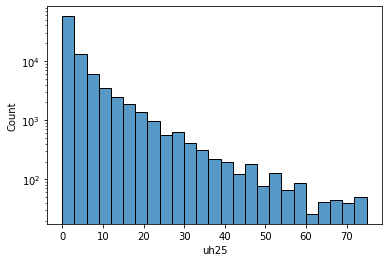

In [17]:
# Seaborn plot generation
import seaborn as sns
import xarray as xr

ds = xr.open_dataset('data/spatial_storm_data_part1.nc')
#print(ds.values)

uh25mx = ds['uh25'].max(['y','x'],skipna=True)
uh25mx = uh25mx.to_dataframe()

sns.histplot(data = uh25mx, x = 'uh25', log_scale=(False,10), bins = 25)

<AxesSubplot:xlabel='Max UH', ylabel='Count'>

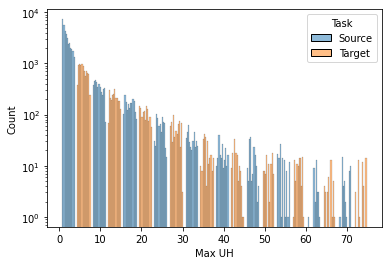

In [48]:
import pandas as pd
# Calculate number of (source) classes to populate w/ high domain gap and low domain gap
n_class = 20
domain_gap = 0.0
split = 0.5
high_cls = n_class * domain_gap * split # Note: these are floats
low_cls = n_class * (1-domain_gap) * split

# Populate high gap classes
source_cls = [x for x in range(math.floor(high_cls))]

# Populate low gap classes
for i in range(math.ceil(low_cls)):
    source_cls.append(math.floor((i * (n_class - high_cls) / low_cls) + high_cls))
    
target_cls = [x for x in range(n_class) if x not in source_cls]

source_or_target = []
#drop = []
for i in range(len(uh25mx)):
    if uh_class[i] in source_cls:
        source_or_target.append('Source')
    elif uh_class[i] in target_cls:
        source_or_target.append('Target')
    #else:
        #drop.append(i)

#newuh25mx = [uh25mx[i] for i in range(len(uh25mx)) if i not in drop]

d = {'Max UH': newuh25mx, 'Task': source_or_target}
df = pd.DataFrame(data=d)
sns.histplot(data=df, x='Max UH', hue = 'Task', log_scale=(False,True))

In [17]:
# Generate mean and stdev for each var
meanarr = []
stdevarr = []
ds2 = ds.drop_vars('uh25')
for var in ds2:
    m = ds2[var].mean()
    s = ds2[var].std()
    print(var, m.item(), s.item())
    meanarr.append(m.item())
    stdevarr.append(s.item())
    
print(meanarr)
print(stdevarr)

tk_1km 280.8821716308594 109.22666931152344
tk_3km 271.5213928222656 109.22666931152344
tk_5km 260.1457214355469 77.23491668701172
tk_7km 246.7049102783203 109.22666931152344
ev_1km 8.42071533203125 8.866754531860352
ev_3km 13.114259719848633 9.56382942199707
ev_5km 16.928213119506836 10.957494735717773
ev_7km 19.719449996948242 11.892759323120117
eu_1km 6.177618026733398 8.308595657348633
eu_3km 13.898662567138672 9.732820510864258
eu_5km 18.913000106811523 11.696307182312012
eu_7km 23.985916137695312 14.249922752380371
qv_1km 0.007207642309367657 0.004077681340277195
qv_3km 0.0046530915424227715 0.0025500282645225525
qv_5km 0.002190731931477785 0.0013640702236443758
qv_7km 0.0007718075066804886 0.0005331166321411729
pr_1km 868.15625 309.60260009765625
pr_3km 678.8226928710938 308.9396667480469
pr_5km 525.4044799804688 195.89791870117188
pr_7km 401.36004638671875 154.46983337402344
wmax 0.40490102767944336 0.48534637689590454
dbz 23.232492446899414 15.682641983032227
ctt 8.56252193450